In [3]:
!pip install fastai

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
from fastai.vision.all import *

In [6]:
path = untar_data(URLs.PETS)/'images'

In [7]:
def is_cat(x): return x[0].isupper()

In [8]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

In [9]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.164090,0.022428,0.008119,11:32


epoch,train_loss,valid_loss,error_rate,time
0,0.064435,0.040859,0.010149,17:45


In [24]:
import ipywidgets as widgets

In [29]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [30]:
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: True.
Probability it's a cat: 1.000000


In [31]:
print(probs)

tensor([2.2164e-15, 1.0000e+00])


### Segmentation

In [32]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,4.072709,2.650130,00:36


epoch,train_loss,valid_loss,time
0,1.876085,1.611020,00:36
1,1.579948,1.287615,00:32
2,1.412320,1.224604,00:25
3,1.301504,1.008895,00:29
4,1.181640,0.976134,00:28
5,1.071055,0.903650,00:28
6,0.980892,0.828236,00:27
7,0.907471,0.827158,00:27


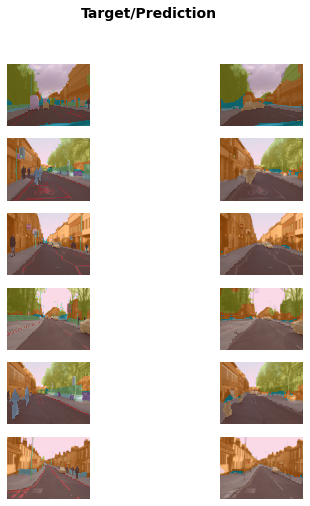

In [38]:
learn.show_results(max_n=6, figsize=(7,8))

### NLP Sentiment analysis

In [1]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=32)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


KeyboardInterrupt: 

In [57]:
import shutil

In [58]:
print(untar_data(URLs.IMDB).ls())

[Path('C:/Users/venka/.fastai/data/imdb/train')]


In [59]:
shutil.rmtree('C:/Users/venka/.fastai/data/imdb_tok')

### Tabular data

In [2]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

In [3]:
doc(learn.predict)

TabularLearner.predict(row: 'pd.Series')
Predict on a single sample

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [4]:
!pip install nbdev


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [5]:
doc(learn.predict)

In [6]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.392559,0.369131,0.820639,00:06
1,0.351119,0.353063,0.832924,00:05
2,0.352222,0.347456,0.837531,00:04


### Recommender Systems:

In [7]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.496300,1.466954,00:00


epoch,train_loss,valid_loss,time
0,1.345784,1.406842,00:00
1,1.251926,1.217320,00:00
2,1.023627,0.893989,00:00
3,0.799598,0.741906,00:00
4,0.685011,0.702829,00:00
5,0.653854,0.687690,00:00
6,0.634331,0.683683,00:00
7,0.616886,0.680767,00:00
8,0.621088,0.679967,00:00
9,0.614139,0.679818,00:00


In [8]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,1.0,71.0,4.0,3.527597
1,52.0,55.0,4.0,4.537408
2,6.0,48.0,4.5,3.811206
3,47.0,36.0,4.0,3.968906
4,41.0,59.0,4.0,3.847852
5,49.0,50.0,4.0,3.999453
6,71.0,81.0,4.5,4.472686
7,86.0,64.0,3.5,3.781282
8,67.0,50.0,3.5,3.224084


### Production

In [2]:
from fastai.vision.widgets import *

In [11]:
??verify_images

Object `verify_images` not found.


In [12]:
%debug

> c:\programdata\anaconda3\lib\pathlib.py(1077)_opener()
   1075     def _opener(self, name, flags, mode=0o666):
   1076         # A stub for the opener argument to built-in open()
-> 1077         return self._accessor.open(self, flags, mode)
   1078 
   1079     def _raw_open(self, flags, mode=0o777):

ipdb> 
ipdb> ??verify_images
*** No help for '?verify_images'
ipdb> q


In [6]:
path=Path(r"C:\Users\venka\OneDrive\ML\tumour_dataset")

In [7]:
tumour = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [9]:
dls = tumour.dataloaders(path)

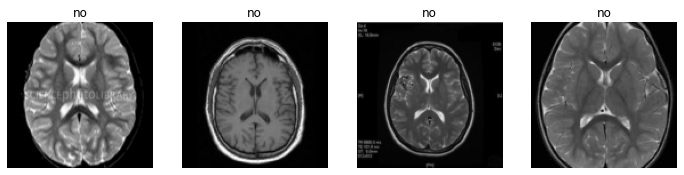

In [10]:
dls.valid.show_batch(max_n=4, nrows=1)

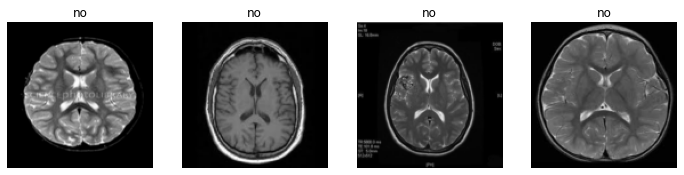

In [11]:
tumour = tumour.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = tumour.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

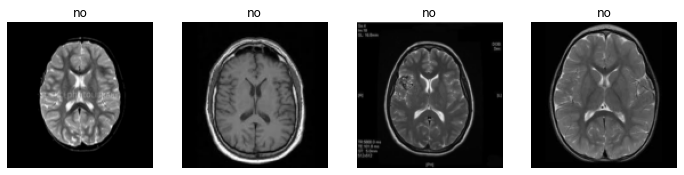

In [12]:
tumour = tumour.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = tumour.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

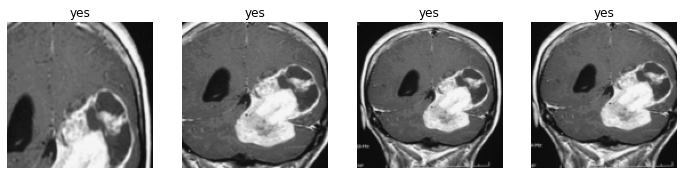

In [13]:
tumour = tumour.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = tumour.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

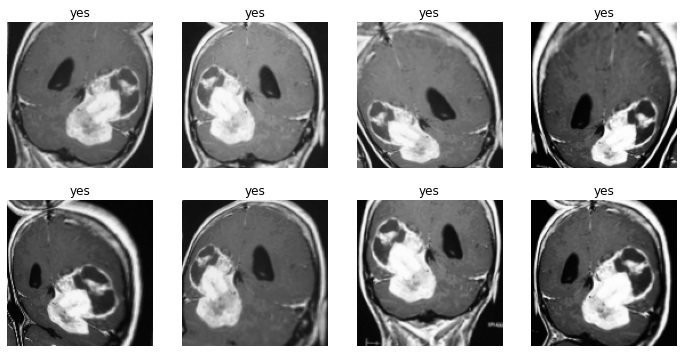

In [14]:
tumour = tumour.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = tumour.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Train the model

In [15]:
tumour = tumour.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = tumour.dataloaders(path)

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\venka/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:12<00:00, 3.80MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.139740,0.518198,0.227723,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.617418,0.309791,0.148515,00:34
1,0.504009,0.272714,0.128713,00:33
2,0.431280,0.158226,0.049505,00:33
3,0.382965,0.131467,0.039604,00:34


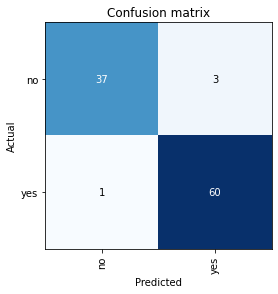

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

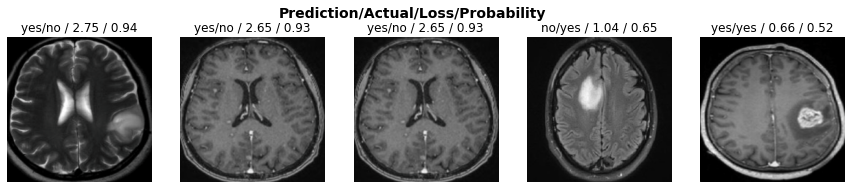

In [18]:
interp.plot_top_losses(5, nrows=1)

In [19]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [20]:
learn.export()

In [21]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [24]:
learn_inf = load_learner(path/'export.pkl')

In [25]:
learn_inf.predict('brain1.jpeg')

('yes', tensor(1), tensor([0.3998, 0.6002]))

In [26]:
learn_inf.dls.vocab

['no', 'yes']

In [27]:
import ipywidgets as widgets

In [28]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [29]:
img = PILImage.create(btn_upload.data[-1])

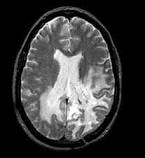

In [30]:
img

In [31]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [32]:
pred,pred_idx,probs = learn_inf.predict(img)

In [33]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: yes; Probability: 0.6002')

In [34]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [35]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

### VBox

In [36]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [37]:
#hide_output
VBox([widgets.Label('Select your image!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [38]:
!pip install voila

  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.0.5
    Uninstalling traitlets-5.0.5:
      Successfully uninstalled traitlets-5.0.5
  Attempting uninstall: pywin32
    Found existing installation: pywin32 227
    Uninstalling pywin32-227:
      Successfully uninstalled pywin32-227
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 2.0.2
    Uninstalling platformdirs-2.0.2:
      Successfully uninstalled platformdirs-2.0.2
  Attempting uninstall: jupyter-core
    Found existing installation: jupyter-core 4.7.1
    Uninstalling jupyter-core-4.7.1:
      Successfully uninstalled jupyter-core-4.7.1
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.1.3
    Uninstalling nbformat-5.1.3:
      Successfully uninstalled nbformat-5.1.3
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 1.1.1
    Uninstalling MarkupSafe-1.1.1:


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.

    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.0.7
    Uninstalling nbconvert-6.0.7:
      Successfully uninstalled nbconvert-6.0.7
  Attempting uninstall: anyio
    Found existing installation: anyio 2.2.0
    Uninstalling anyio-2.2.0:
      Successfully uninstalled anyio-2.2.0
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-server 1.4.1
    Uninstalling jupyter-server-1.4.1:
      Successfully uninstalled jupyter-server-1.4.1



anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.
virtualenv 20.6.0 requires platformdirs<3,>=2, but you have platformdirs 3.5.3 which is incompatible.
sphinx 4.0.1 requires Jinja2<3.0,>=2.3, but you have jinja2 3.1.2 which is incompatible.
sphinx 4.0.1 requires MarkupSafe<2.0, but you have markupsafe 2.1.3 which is incompatible.
You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [39]:
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: C:\ProgramData\Anaconda3\etc\jupyter
    - Validating...
      voila 0.4.0 ok
